# LSTM for Time Series
### With TensorFlow/Keras: Multivariate time series

In [81]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow.keras.models as tkm
import tensorflow.keras.layers as tkl

## Load and transform dataset

In [118]:
ds = pd.read_csv('D:/data/csv/airpolution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))
ds.drop('No', axis=1, inplace=True)
ds.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
ds.index.name = 'date'
ds['pollution'].fillna(0, inplace=True)
ds = ds[24:] # drop first 24 hours
ds.to_csv('D:/data/csv/pollution.csv')
ds.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Load and plot data

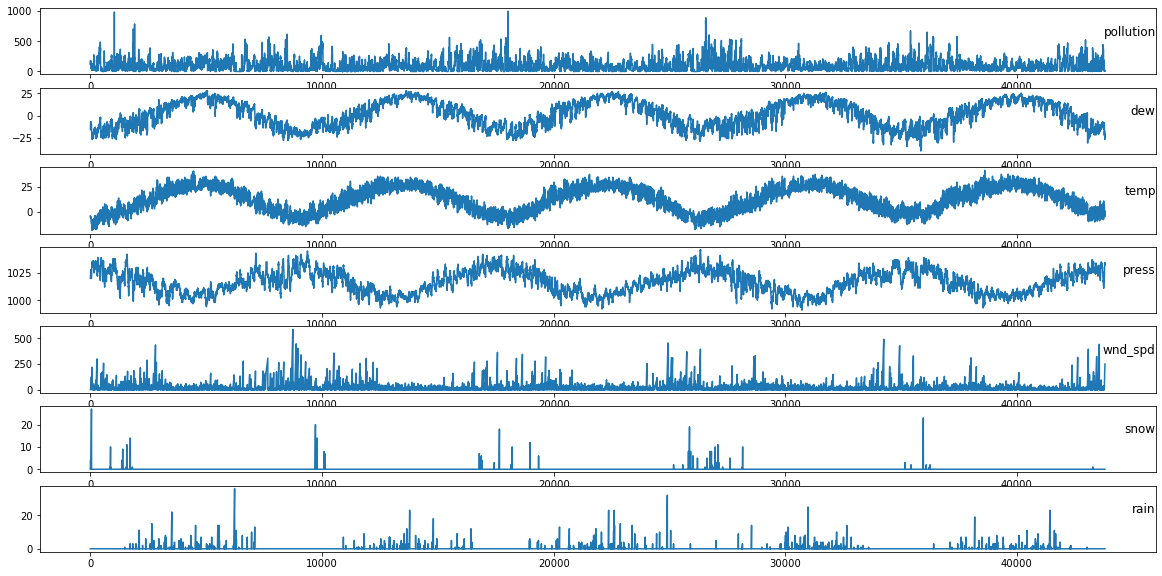

In [119]:
data = pd.read_csv('D:/data/csv/pollution.csv', header=0, index_col=0)
mts = data.values
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6, 7]
i = 1
plt.figure(figsize=(20,10))
for c in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(mts[:, c])
    plt.title(data.columns[c], y=0.5, loc='right')
    i += 1
plt.show()

### Data preparation

In [120]:
def build_ds(mts, n_in=1, n_out=1, dropnan=True):
    nvars = mts.shape[1]
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(mts.shift(i, axis=0))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(nvars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(mts.shift(-i, axis=0))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(nvars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(nvars)]
    
    ds = pd.concat(cols, axis=1)
    ds.columns = names
    if dropnan:
        ds.dropna(inplace=True)
    return ds

In [121]:
print(ds.shape)
mts = ds.values
len(mts), len(mts[0])

(43800, 8)


(43800, 8)

In [122]:
encoder = LabelEncoder()
mts[:,4] = encoder.fit_transform(mts[:,4])
mts = mts.astype('float32')
len(mts), len(mts[0])

(43800, 8)

In [123]:
scaler = MinMaxScaler(feature_range=(0, 1))
mts_sc = scaler.fit_transform(mts)
len(mts_sc), len(mts_sc[0])

(43800, 8)

In [124]:
mts_sc = pd.DataFrame(mts_sc)
ds = build_ds(mts_sc, 1, 1)
ds.shape
ds.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [125]:
ds.drop(ds.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True) #keep only hist (var1 observable and regressors) cols and cols to predict (observable(s))
ds.head()
 

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


### Split into train and test / inputs and outputs

In [126]:
values = ds.values
n_train_hours = 365*24
ds_train = values[:n_train_hours, :]
ds_test = values[n_train_hours:, :]

X_train, y_train = ds_train[:, :-1], ds_train[:, -1]
X_test, y_test = ds_test[:, :-1], ds_test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train[0:5])

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
[[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
   0.         0.        ]]

 [[0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
   0.         0.        ]]

 [[0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
   0.         0.        ]]

 [[0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
   0.03703704 0.        ]]

 [[0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
   0.07407407 0.        ]]]


In [156]:
ds.values

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.        , 0.        ,
        0.14889336],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.        , 0.        ,
        0.15995975],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.        , 0.        ,
        0.18209255],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.        , 0.        ,
        0.01006036],
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.        , 0.        ,
        0.00804829],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.        , 0.        ,
        0.01207243]], dtype=float32)

## Modelling

Epoch 1/50
122/122 - 1s - loss: 0.0591 - val_loss: 0.0605
Epoch 2/50
122/122 - 1s - loss: 0.0403 - val_loss: 0.0668
Epoch 3/50
122/122 - 1s - loss: 0.0245 - val_loss: 0.0528
Epoch 4/50
122/122 - 1s - loss: 0.0180 - val_loss: 0.0438
Epoch 5/50
122/122 - 1s - loss: 0.0161 - val_loss: 0.0295
Epoch 6/50
122/122 - 1s - loss: 0.0152 - val_loss: 0.0201
Epoch 7/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0172
Epoch 8/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0163
Epoch 9/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0155
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0153
Epoch 11/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0152
Epoch 12/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0149
Epoch 13/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0149
Epoch 14/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 15/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0143
Epoch 16/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0140
Epoch 17/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 

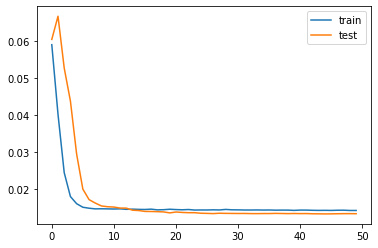

In [127]:
model = tkm.Sequential()
model.add(tkl.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tkl.Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Validation

In [128]:
pred = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

# invert scaling for forecast
pred_inv = np.concatenate((pred, X_test[:, 1:]), axis=1)
pred_inv = scaler.inverse_transform(pred_inv)
pred_inv = pred_inv[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
y_inv = np.concatenate((y_test, X_test[:, 1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]
print(y_inv)
# calculate RMSE
rmse = sqrt(mean_squared_error(y_inv, pred_inv))
print('Test RMSE: %.3f' % rmse)

[31. 20. 19. ... 10.  8. 12.]
Test RMSE: 26.484


In [161]:
res = pd.DataFrame(y_inv, columns=['real'])
res['pred'] = np.round(pred_inv)
res

,real,pred
0,31.0,34.0
1,20.0,31.0
2,19.0,20.0
3,18.0,19.0
4,17.0,19.0
...,...,...
35034,8.0,8.0
35035,10.0,6.0
35036,10.0,8.0
35037,8.0,8.0


## Credits & Links

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/